<h2 style="text-align: center;"><span style="color: #333399;">Lab Course: Distributed Data Analytics</span><br /><span style="color: #333399;">Exercise Sheet 8</span></h2>
<h3 style="text-align: center;"><span style="color: #333399;">Syed Wasif Murtaza Jafri- 311226</span></h3>

# Exercise 1: Apache Spark Basics
## <strong> Part a) Basic Operations on Resilient Distributed Dataset (RDD)
<p><strong>Let's have two lists of words as follows:</strong></p>
<p><strong>&bull; a = ["spark", "rdd", "python", "context", "create", "class"]</strong></p>
<p><strong>&bull; b = ["operation", "apache", "scala", "lambda","parallel","partition"]</strong></p>
<p><strong>Create two RDD objects of a, b and do the following tasks. Words should be remained in the results </strong><strong>of join operations.

In [150]:
from operator import add
from pyspark.sql import functions as F
from collections import Counter
from pyspark.sql.functions import udf
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from datetime import date
from datetime import datetime
import dateutil
from pyspark.sql.types import *
from pyspark.sql import Window
from collections import Counter
import statistics
from itertools import chain

In [54]:
# storing session context in variable
sc= SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=PySparkShell>

local[*] means pyspark will create workers equal to number of cores in pc.

### <strong> 1. Perform rightOuterJoin and fullOuterJoin operations between a and b. Briefly explain your solution.</strong>

First, I initalized two lists a and b. Then I converted both list into list of tuple combining every word in list with it a unique number as rdd join operation requires tuple list.Then I created two RDDs with both tuple list and applied right and inner join operation and then converted back to list.

In [61]:
a = ["spark", "rdd", "python", "context", "create", "class"]
# for rdd converting list to tuple
a_tuple = list(zip(a, list(range(1,len(a)+1))))
print('a_tuple:',a_tuple)

b = ["operation", "apache", "scala", "lambda","parallel","partition"]
# for rdd converting list to tuple
b_tuple = list(zip(b, list(range(1,len(b)+1))))
print('b_tuple:',b_tuple)

# parallelizing both rdds
a_rdd = sc.parallelize(a_tuple)
b_rdd =sc.parallelize(b_tuple)


a_tuple: [('spark', 1), ('rdd', 2), ('python', 3), ('context', 4), ('create', 5), ('class', 6)]
b_tuple: [('operation', 1), ('apache', 2), ('scala', 3), ('lambda', 4), ('parallel', 5), ('partition', 6)]


In [60]:
# taking right outer join of a_rdd with b_rdd
right_outer_join= a_rdd.rightOuterJoin(b_rdd)
print('Right Outer Join:',right_outer_join.collect())

# converting back to list
right_outer_join_list = right_outer_join.map(lambda x:x[0])
print('Right Outer Join List:',right_outer_join_list.collect())

Right Outer Join: [('parallel', (None, 5)), ('lambda', (None, 4)), ('scala', (None, 3)), ('operation', (None, 1)), ('apache', (None, 2)), ('partition', (None, 6))]
Right Outer Join List: ['parallel', 'lambda', 'scala', 'operation', 'apache', 'partition']


In [58]:
# taking full outer join of a_rdd with b_rdd
full_outer_join= (a_rdd.fullOuterJoin(b_rdd))
print('Full Outer Join:',full_outer_join.collect())

# converting back to list
full_outer_join_list = full_outer_join.map(lambda x:x[0])
print('Full Outer Join List:',full_outer_join_list.collect())

Full Outer Join: [('python', (3, None)), ('spark', (1, None)), ('context', (4, None)), ('create', (5, None)), ('parallel', (None, 5)), ('lambda', (None, 4)), ('class', (6, None)), ('rdd', (2, None)), ('scala', (None, 3)), ('operation', (None, 1)), ('apache', (None, 2)), ('partition', (None, 6))]
Full Outer Join List: ['python', 'spark', 'context', 'create', 'parallel', 'lambda', 'class', 'rdd', 'scala', 'operation', 'apache', 'partition']


### <strong>2. Using map and reduce functions to count how many times the character "s" appears in all a and </strong><strong>b.</strong>

Counting occurance of 's' character in both rdd with help of map function aand then taking union of count Rdds. Reduce sums the counts in final count Rdd.

In [67]:
# parallelizing list a and b
a_rdd = sc.parallelize(a)
b_rdd =sc.parallelize(b)

# combining both rdds
c_rdd = a_rdd.union(b_rdd)
print('Combined RDD:',c_rdd.collect())

# counting s character in each word of list a and b
count_rdd = c_rdd.map(lambda x:x.count('s'))
print('Count of s in all a and b:',count_rdd.collect())

# summing counts with reduce 
total_count = count_rdd.reduce(add)
print('Total count of s: ',total_count)

Combined RDD: ['spark', 'rdd', 'python', 'context', 'create', 'class', 'operation', 'apache', 'scala', 'lambda', 'parallel', 'partition']
Count of s in all a and b: [1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0]
Total count of s:  4


### <strong>3. Using aggregate function to count how many times the character "s" appears in all a and b.</strong></p>

Aggregate function take 3 arguments,zeroValue which is initial value for result,seqOp which defines operation you want to apply on Rdd and  combOp which combines results from different partitions.seqOp gives counts for each partition and then combOp is combining results from each partition to give final count.

In [69]:
# parallelizing list a and b
a_rdd = sc.parallelize(a)
b_rdd =sc.parallelize(b)

# combining both rdds
c_rdd = a_rdd.union(b_rdd)
print('Combined RDD:',c_rdd.collect())

# defining seqOp argument which calculates count in each partition
seqOp = (lambda local_result, list_element: (local_result + list_element.count('s')) )

# defining combOp argument which combine count from partition
combOp = (lambda some_local_result, another_local_result: (some_local_result + another_local_result) )

rdd_c_agg =  rdd_c.aggregate( 0, seqOp, combOp)
print('Count of s with aggregate:',rdd_c_agg)



Combined RDD: ['spark', 'rdd', 'python', 'context', 'create', 'class', 'operation', 'apache', 'scala', 'lambda', 'parallel', 'partition']
Count of s with aggregate: 4


## <strong> Part b) Basic Operations on DataFrames
<strong>Use dataset students.json (download from learnweb) for this exercise. First creating DataFrames from the dataset and do several tasks as follows:</strong>


In [114]:
#reading jason
data= sc.textFile('students.json').collect()
df = spark.read.json(sc.parallelize(data))
df.show() 

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

###  <p><strong>1. Replace the null value(s) in column points by the mean of all points.</strong></p>

In [115]:
# calculating mean
meanPoints = df.select(_mean(col('points')).alias('mean')).collect()[0]['mean']
print('Mean:',meanPoints)

# replacing null values with mean
df=df.na.fill(value=meanPoints,subset=["points"])
df.show()
df.printSchema

Mean: 11.736842105263158
+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|     null|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     J

<bound method DataFrame.printSchema of DataFrame[course: string, dob: string, first_name: string, last_name: string, points: bigint, s_id: bigint]>

<b>point column is bigint thats why 11.7 is converted to 11.

### <strong>2. Replace the null value(s) in column dob and column last name by "unknown" and "--" respectively.</strong></p>

In [116]:
# replacing null value in dob colummn with unknown
df=df.na.fill(value="unknown",subset=["dob"])

# replacing null value in last_name colummn with --
df=df.na.fill(value="--",subset=["last_name"])
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

### <strong>3. In the dob column, there exist several formats of dates, e.g. October 14, 1983 and 26 December 1989. Let's convert all the dates into DD-MM-YYYY format where DD, MM and YYYY are two digits for day, two digits for months and four digits for year respectively.</strong></p>

In [117]:
# creating a user defined function which change format
@udf('string')
def changeFormat(date):
    if(date!='unknown'):
        # converting str to datetime
        date = dateutil.parser.parse(date)
        # converting datetime to string of required format
        formatedDateStr = date.strftime("%d-%m-%Y")
        return formatedDateStr
    else:
        # if unknown value comes it returns unknown
        return 'unknown'
    
# updating dob column with udf
df=df.withColumn("dob",changeFormat(df.dob))
df.show()

+------------------+----------+----------+---------+------+----+
|            course|       dob|first_name|last_name|points|s_id|
+------------------+----------+----------+---------+------+----+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1|
|  Computer Science|26-09-1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|12-06-1982|     Athur|   Watson|    16|   3|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|13-01-1978|      John|       --|    10|   8|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    15|   9|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|12-06-1975|     Holly| Schwartz|    12|  11|
|  Computer Science|02-07-1985|     April|    Black|    11|  12|
|  Computer Science|22-07

### <strong>4. Insert a new column age and calculate the current age of all students.</strong></p>

In [118]:
# creating a udf for calculating age from dob for each rows 
@udf("int")
def calculateAge(birthDateStr):
    if(birthDateStr!='unknown'):
        today = date.today()
        # converting string to date
        birthDate = datetime.strptime(birthDateStr, '%d-%m-%Y').date()
        
        # if todays month and date is less than dob month and date then subtracting 1
        age = today.year - birthDate.year-((today.month, today.day) <(birthDate.month, birthDate.day))
    else:
        age = 0
    return age
# creating age column with udf
df=df.withColumn("age",calculateAge(df.dob))
df.show()

+------------------+----------+----------+---------+------+----+---+
|            course|       dob|first_name|last_name|points|s_id|age|
+------------------+----------+----------+---------+------+----+---+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1| 38|
|  Computer Science|26-09-1980|    Martin|  Genberg|    17|   2| 41|
|    Graphic Design|12-06-1982|     Athur|   Watson|    16|   3| 40|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4| 35|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5| 43|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6| 41|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7| 38|
|     Deep Learning|13-01-1978|      John|       --|    10|   8| 44|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    15|   9| 32|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10| 34|
|    Data Analytics|12-06-1975|     Holly| Schwartz|    12|  11| 47|
|  Computer Science|02-07-1985|   

### <strong>5. Let's consider granting some points for good performed students in the class. For each student,f his point is larger than 1 standard deviation of all points, then we update his current point to 20, which is the maximum. See Annex 1 for a tutorial on how to calculate standard deviation.</strong></p>

In [119]:
# calculating standard deviation and adding in a column
stdPoints = df.select(_stddev(col('points')).alias('std')).collect()[0]['std']
print('std of points:',stdPoints)
# adding points to df
df = df.withColumn("std",F.lit(stdPoints))

# calculating mean and adding in a column
meanPoints = df.select(_mean(col('points')).alias('mean')).collect()[0]['mean']
print('mean of points:',meanPoints)
# adding points to df
df = df.withColumn("mean",F.lit(meanPoints))

std of points: 3.2460502314756554
mean of points: 11.7


In [120]:
# defining udf for updating points
@udf("int")
def updatePoints(points,std,mean):
    if points >  mean + std :
        points = 20
    return points

# updating column points and passing 3 columns to udf (points,std,mean)
df=df.withColumn("points",updatePoints(df.points,df.std,df.mean))

# removing extra columns
df=df.drop("std","mean")
df.show()


+------------------+----------+----------+---------+------+----+---+
|            course|       dob|first_name|last_name|points|s_id|age|
+------------------+----------+----------+---------+------+----+---+
|Humanities and Art|14-10-1983|      Alan|      Joe|    10|   1| 38|
|  Computer Science|26-09-1980|    Martin|  Genberg|    20|   2| 41|
|    Graphic Design|12-06-1982|     Athur|   Watson|    20|   3| 40|
|    Graphic Design|05-04-1987|  Anabelle|  Sanberg|    12|   4| 35|
|        Psychology|01-11-1978|      Kira| Schommer|    11|   5| 43|
|          Business|17-02-1981| Christian|   Kiriam|    10|   6| 41|
|  Machine Learning|01-01-1984|   Barbara|  Ballard|    14|   7| 38|
|     Deep Learning|13-01-1978|      John|       --|    10|   8| 44|
|  Machine Learning|26-12-1989|    Marcus|   Carson|    20|   9| 32|
|           Physics|30-12-1987|     Marta|   Brooks|    11|  10| 34|
|    Data Analytics|12-06-1975|     Holly| Schwartz|    12|  11| 47|
|  Computer Science|02-07-1985|   

### <strong>6. Create a histogram on the new points created in the task 5.</strong></p>

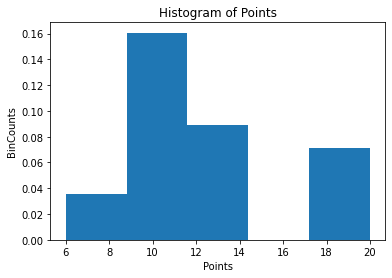

In [112]:
# converting column to list of points
points_array = sorted([int(row.points) for row in df.select('points').collect()])
  
# Plotting the histogram.
plt.hist(points_array, bins=5, density=True)
plt.xlabel('Points')
plt.ylabel('BinCounts')
plt.title(r'Histogram of Points')
plt.show()

# Exercise 2: Manipulating Recommender Dataset with Apache Spark
<p><strong>For this exercise you will use movielens10m dataset available at https://grouplens.org/datasets/ movielens/10m/. The movielens dataset is a rating prediction dataset with ratings given on a scale of 1 to 5. Specifically, you will be working with Tags Data File Structure tags.dat, which contains data in the form \UserID::MovieID::Tag::Timestamp". You have to solve following questions using Apache Spark transformations and actions.</strong></p>


In [125]:
from pyspark.sql.types import *
schema = StructType().add("UserID",IntegerType(),True).add("MovieID",IntegerType(),True).add("Tag",StringType(),True).add("Timestamp",IntegerType())
tags=spark.read.options(delimiter=':').schema(schema).csv("tags.dat")
tags.show()

+------+-------+--------------------+----------+
|UserID|MovieID|                 Tag| Timestamp|
+------+-------+--------------------+----------+
|    15|   4973|          excellent!|1215184630|
|    20|   1747|            politics|1188263867|
|    20|   1747|              satire|1188263867|
|    20|   2424|     chick flick 212|1188263835|
|    20|   2424|               hanks|1188263835|
|    20|   2424|                ryan|1188263835|
|    20|   2947|              action|1188263755|
|    20|   2947|                bond|1188263756|
|    20|   3033|               spoof|1188263880|
|    20|   3033|           star wars|1188263880|
|    20|   7438|              bloody|1188263801|
|    20|   7438|             kung fu|1188263801|
|    20|   7438|           Tarantino|1188263801|
|    21|  55247|                   R|1205081506|
|    21|  55253|               NC-17|1205081488|
|    25|     50|        Kevin Spacey|1166101426|
|    25|   6709|         Johnny Depp|1162147221|
|    31|     65|    

### <strong>1. A tagging session for a user can be defined as the duration in which he/she generated tagging activities. Typically, an inactive duration of 30 mins is considered as a termination of the tagging session. Your task is to separate out tagging sessions for each user.</strong></p>

In [132]:
# creating a window for grouping user ids order by timestamp
w = Window.partitionBy('UserID').orderBy('Timestamp')

# creating new dataframe and adding userIds and corresponding timestamps in one row
# collect_list is collecting timestamps of each user in the window, then grouped by userID to merge same userID rows
session_list_df = tags.withColumn('timestamp_list', F.collect_list('Timestamp').over(w)).groupBy('UserID').agg(F.max('timestamp_list').alias('timestamp_list'))

# ordering dataframe with userIds
session_list_df = session_list_df.orderBy(F.col("UserID").asc()).na.drop()
session_list_df.show()


+------+--------------------+
|UserID|      timestamp_list|
+------+--------------------+
|    15|        [1215184630]|
|    20|[1188263755, 1188...|
|    21|[1205081488, 1205...|
|    25|[1162147221, 1166...|
|    31|[1188263644, 1188...|
|    32|        [1164735331]|
|    39|[1188263764, 1188...|
|    48|[1215135517, 1215...|
|    49|[1188264095, 1188...|
|    75|        [1162160415]|
|    78|        [1176691425]|
|   109|[1165554764, 1165...|
|   127|[1188265347, 1188...|
|   133|[1188265375, 1188...|
|   146|[1147948639, 1148...|
|   147|[1162188631, 1162...|
|   170|        [1162209176]|
|   175|[1188441420, 1192...|
|   181|[1188266123, 1188...|
|   190|[1140031954, 1140...|
+------+--------------------+
only showing top 20 rows



In [133]:
# creating a udf which takes timestamp_list column and for each user , compare timestamp with previous one and assign session
@udf(returnType=ArrayType(IntegerType()))
def createSession(timeStampList):
    session_list=[]
    for i in range(len(timeStampList)):
        if(i!=0):
            # if timestamp difference is less than 1800 seconds then session is not changed
            if((timeStampList[i]-timeStampList[i-1]) < 1800):
                session=previous_session

            else:
                session=previous_session+1
        else:
            session=1
        session_list.append(session)
        previous_session=session
            

    return session_list
#calling udf for adding session_list column which has session ids for each tag
session_list_df=session_list_df.withColumn("session_list",createSession(session_list_df.timestamp_list))
session_list_df.show()

+------+--------------------+--------------------+
|UserID|      timestamp_list|        session_list|
+------+--------------------+--------------------+
|    15|        [1215184630]|                 [1]|
|    20|[1188263755, 1188...|[1, 1, 1, 1, 1, 1...|
|    21|[1205081488, 1205...|              [1, 1]|
|    25|[1162147221, 1166...|              [1, 2]|
|    31|[1188263644, 1188...|     [1, 1, 1, 1, 1]|
|    32|        [1164735331]|                 [1]|
|    39|[1188263764, 1188...|     [1, 1, 1, 1, 1]|
|    48|[1215135517, 1215...|              [1, 1]|
|    49|[1188264095, 1188...|[1, 1, 1, 1, 1, 1...|
|    75|        [1162160415]|                 [1]|
|    78|        [1176691425]|                 [1]|
|   109|[1165554764, 1165...|[1, 1, 1, 1, 1, 1...|
|   127|[1188265347, 1188...|[1, 1, 1, 1, 1, 1...|
|   133|[1188265375, 1188...|     [1, 1, 1, 1, 1]|
|   146|[1147948639, 1148...|[1, 2, 3, 3, 4, 4...|
|   147|[1162188631, 1162...|              [1, 1]|
|   170|        [1162209176]|  

In [137]:
# showing sessoion list of tags for userID 109
session_list_df.filter(session_list_df.UserID==109).collect()[0]['session_list']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 6, 7, 7, 7, 7, 8, 9]


### <strong>2. Once you have all the tagging sessions for each user, calculate the frequency of tagging for each user session</strong></p>

In [138]:
# creating udf for calculating frequency from session list
@udf(returnType=ArrayType(IntegerType()))
def CountFrequency(sessionList):
    # count each session id in list
    C = Counter(sessionList)
    return list(C.values())

# calling udf and creating new column frequence_of_tagging
session_list_df=session_list_df.withColumn("frequence_of_tagging",CountFrequency(session_list_df.session_list))
session_list_df.show()

+------+--------------------+--------------------+--------------------+
|UserID|      timestamp_list|        session_list|frequence_of_tagging|
+------+--------------------+--------------------+--------------------+
|    15|        [1215184630]|                 [1]|                 [1]|
|    20|[1188263755, 1188...|[1, 1, 1, 1, 1, 1...|                [12]|
|    21|[1205081488, 1205...|              [1, 1]|                 [2]|
|    25|[1162147221, 1166...|              [1, 2]|              [1, 1]|
|    31|[1188263644, 1188...|     [1, 1, 1, 1, 1]|                 [5]|
|    32|        [1164735331]|                 [1]|                 [1]|
|    39|[1188263764, 1188...|     [1, 1, 1, 1, 1]|                 [5]|
|    48|[1215135517, 1215...|              [1, 1]|                 [2]|
|    49|[1188264095, 1188...|[1, 1, 1, 1, 1, 1...|                [15]|
|    75|        [1162160415]|                 [1]|                 [1]|
|    78|        [1176691425]|                 [1]|              

In [140]:
# showing frequency list of tags for each session for userID 109
session_list_df.filter(session_list_df.UserID==109).collect()[0]['frequence_of_tagging']

[11, 2, 3, 1, 1, 1, 4, 1, 1]

### <strong>3. Find a mean and standard deviation of the tagging frequency of each user.</strong></p>

In [164]:
# creating udf for calculating mean frequency tagging for each session of user
@udf(FloatType())
def CalculateMean(freqList):
    sum= 0
    for i in range(len(freqList)):
        sum += freqList[i]
    return sum/(len(freqList))

session_list_df=session_list_df.withColumn("mean_Frequency_each_user",CalculateMean(session_list_df.frequence_of_tagging))

# creating udf for calculating std of frequency tagging for each session of user
@udf(FloatType())
def CalculateStd(freqList):
    std = 0.0
    if(len(freqList)>1):
        std = statistics.stdev(freqList)
    return std

session_list_df=session_list_df.withColumn("std_Frequency_each_user",CalculateStd(session_list_df.frequence_of_tagging))
session_list_df.select(['UserID','frequence_of_tagging','mean_Frequency_each_user','std_Frequency_each_user']).show()


+------+--------------------+------------------------+-----------------------+
|UserID|frequence_of_tagging|mean_Frequency_each_user|std_Frequency_each_user|
+------+--------------------+------------------------+-----------------------+
|    15|                 [1]|                     1.0|                    0.0|
|    20|                [12]|                    12.0|                    0.0|
|    21|                 [2]|                     2.0|                    0.0|
|    25|              [1, 1]|                     1.0|                    0.0|
|    31|                 [5]|                     5.0|                    0.0|
|    32|                 [1]|                     1.0|                    0.0|
|    39|                 [5]|                     5.0|                    0.0|
|    48|                 [2]|                     2.0|                    0.0|
|    49|                [15]|                    15.0|                    0.0|
|    75|                 [1]|                     1.

In [144]:
# showing mean of frequency list of tags for each session for userID 109
session_list_df.filter(session_list_df.UserID==109).collect()[0]['mean_Frequency_each_user']

2.777777671813965

In [145]:
# showing  std of frequency list of tags for each session for userID 109
session_list_df.filter(session_list_df.UserID==109).collect()[0]['std_Frequency_each_user']

3.2702362537384033

### <strong>4. Find a mean and standard deviation of the tagging frequency for across users.</strong></p>

In [156]:
# converting frequence_of_tagging to 2d list and then converting it to ID
frequency_list = list(chain.from_iterable(session_list_df.select('frequence_of_tagging').rdd.flatMap(lambda x: x).collect()))


In [165]:
# calculating std and adding in a column
stdPoints = statistics.stdev(frequency_list)
session_list_df = session_list_df.withColumn("std_across_user",F.lit(stdPoints))

# calculating mean and adding in a column
meanPoints = statistics.mean(frequency_list)
session_list_df = session_list_df.withColumn("mean_across_user",F.lit(meanPoints))
session_list_df.select(['UserID','mean_Frequency_each_user','std_Frequency_each_user','mean_across_user','std_across_user']).show()

+------+------------------------+-----------------------+----------------+-----------------+
|UserID|mean_Frequency_each_user|std_Frequency_each_user|mean_across_user|  std_across_user|
+------+------------------------+-----------------------+----------------+-----------------+
|    15|                     1.0|                    0.0|7.17114764172684|22.07944597647594|
|    20|                    12.0|                    0.0|7.17114764172684|22.07944597647594|
|    21|                     2.0|                    0.0|7.17114764172684|22.07944597647594|
|    25|                     1.0|                    0.0|7.17114764172684|22.07944597647594|
|    31|                     5.0|                    0.0|7.17114764172684|22.07944597647594|
|    32|                     1.0|                    0.0|7.17114764172684|22.07944597647594|
|    39|                     5.0|                    0.0|7.17114764172684|22.07944597647594|
|    48|                     2.0|                    0.0|7.17114764172

In [166]:
print('Std accross user:',statistics.stdev(frequency_list))
print('Mean accross user:',statistics.mean(frequency_list))

Std accross user: 22.07944597647594
Mean accross user: 7.17114764172684


### <strong> 5. Provide the list of users with a mean tagging frequency within the two standard deviation from the mean frequency of all users.

In [167]:
# defining udf which puts 1 in is_two_std_from_mean column if users mean frequency is under 2*StandarDeviation else 0
@udf("int")
def checkStdFromMean(freq,std,mean):
    if mean - 2 * std < freq < mean + 2 * std:
        return 1
    else:
        return 0

session_list_df=session_list_df.withColumn("is_two_std_from_mean",checkStdFromMean(session_list_df.mean_Frequency_each_user,session_list_df.std_across_user,session_list_df.mean_across_user))
session_list_df.select(['UserID','mean_Frequency_each_user','std_across_user','mean_across_user','is_two_std_from_mean']).show()


+------+------------------------+-----------------+----------------+--------------------+
|UserID|mean_Frequency_each_user|  std_across_user|mean_across_user|is_two_std_from_mean|
+------+------------------------+-----------------+----------------+--------------------+
|    15|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    20|                    12.0|22.07944597647594|7.17114764172684|                   1|
|    21|                     2.0|22.07944597647594|7.17114764172684|                   1|
|    25|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    31|                     5.0|22.07944597647594|7.17114764172684|                   1|
|    32|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    39|                     5.0|22.07944597647594|7.17114764172684|                   1|
|    48|                     2.0|22.07944597647594|7.17114764172684|                   1|
|    49|  

In [168]:
# showing users within 2 std from mean frequency
session_list_df.filter(session_list_df.is_two_std_from_mean==1).select(['UserID','mean_Frequency_each_user','std_across_user','mean_across_user','is_two_std_from_mean']).show()

+------+------------------------+-----------------+----------------+--------------------+
|UserID|mean_Frequency_each_user|  std_across_user|mean_across_user|is_two_std_from_mean|
+------+------------------------+-----------------+----------------+--------------------+
|    15|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    20|                    12.0|22.07944597647594|7.17114764172684|                   1|
|    21|                     2.0|22.07944597647594|7.17114764172684|                   1|
|    25|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    31|                     5.0|22.07944597647594|7.17114764172684|                   1|
|    32|                     1.0|22.07944597647594|7.17114764172684|                   1|
|    39|                     5.0|22.07944597647594|7.17114764172684|                   1|
|    48|                     2.0|22.07944597647594|7.17114764172684|                   1|
|    49|  

In [163]:
user_List_with_2_std = sorted([int(row.UserID) for row in session_list_df.filter(session_list_df.is_two_std_from_mean==1).collect()])
user_List_with_2_std

[15,
 20,
 21,
 25,
 31,
 32,
 39,
 48,
 49,
 75,
 78,
 109,
 127,
 133,
 146,
 147,
 170,
 175,
 181,
 190,
 222,
 233,
 240,
 249,
 267,
 283,
 284,
 299,
 325,
 374,
 383,
 423,
 442,
 457,
 476,
 477,
 487,
 493,
 498,
 514,
 519,
 528,
 533,
 538,
 545,
 548,
 580,
 611,
 615,
 622,
 626,
 636,
 637,
 673,
 682,
 687,
 692,
 713,
 717,
 722,
 728,
 732,
 760,
 778,
 783,
 788,
 845,
 850,
 858,
 877,
 880,
 894,
 922,
 929,
 937,
 944,
 959,
 981,
 985,
 1000,
 1010,
 1017,
 1035,
 1036,
 1042,
 1047,
 1049,
 1056,
 1081,
 1117,
 1118,
 1122,
 1137,
 1160,
 1164,
 1170,
 1174,
 1188,
 1198,
 1210,
 1224,
 1225,
 1241,
 1246,
 1267,
 1272,
 1278,
 1282,
 1295,
 1298,
 1338,
 1355,
 1356,
 1362,
 1379,
 1392,
 1393,
 1436,
 1443,
 1447,
 1457,
 1496,
 1504,
 1510,
 1539,
 1547,
 1553,
 1565,
 1575,
 1600,
 1613,
 1622,
 1632,
 1652,
 1663,
 1670,
 1682,
 1698,
 1713,
 1724,
 1728,
 1751,
 1757,
 1778,
 1806,
 1858,
 1860,
 1894,
 1910,
 1915,
 1920,
 1946,
 1967,
 1972,
 1988,
 2000

Reference:
https://stackoverflow.com/questions/28240706/explain-the-aggregate-functionality-in-spark-with-python-and-scala